# SSVEP: Offline processing using threshold-based method

## Step 0: Import neceessary toolboxes

In [1]:
import mne
import numpy as np
import scipy
from mne.datasets import eegbci
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## Step 1: Read data file

In [2]:
# read biosemi file (bdf)
raw = mne.io.read_raw_bdf("Testdata3.bdf", preload=True, verbose=False) 
eegbci.standardize(raw)

## Step 2: Data preprocessing -- set channel locations/ downsampling/ frequency filtering (bandpass)/ epoching

In [3]:
# Set channel location
montage = make_standard_montage("biosemi64")
raw.set_montage(montage, on_missing='ignore')

# Downsample data (from 1024 to 512Hz) to save storage space 
raw = raw.resample(512, verbose = False)

# Bandpass filter 
raw = raw.filter(l_freq=1, h_freq=40, verbose = False)

# Get events and timestamps
events = mne.find_events(raw, shortest_event = 0, verbose = False) 

# Create event dictionary 
event_dict =  {'12Hz': 8,
'24Hz': 4,
'6Hz': 10,
'30Hz': 2
}

# Use events and event dictionary to cut data into Epochs
ssvep_chans = ['O1','O2','Oz']
Epochs = mne.Epochs(raw, events, 
    tmin= -1.0,  
    tmax= 4.0,    
    event_id=event_dict,
    picks = ssvep_chans,
    preload = True,
    event_repeated='drop',
    baseline=(-1.0, 0.0),
    verbose=False
)



## Step 2.5: Visualize the outcomes of data-preprocessing

The outcome of pre-processing is data variable called "Epochs". 

This data variable has 3 dimensions = 61 epochs x 73 channels x 3073 time points

Averaging across epochs...


C:\Users\pipo_\AppData\Roaming\Python\Python311\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


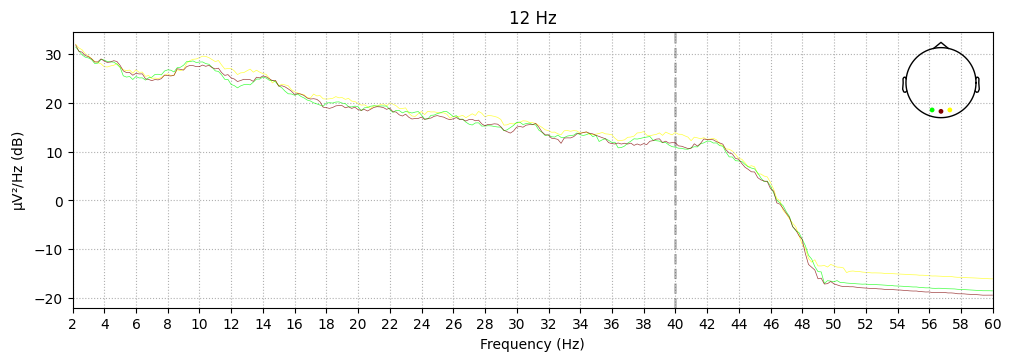

<Epochs |  20 events (all good), -1 – 4 s, baseline -1 – 0 s, ~1.2 MB, data loaded,
 '12Hz': 5
 '24Hz': 5
 '6Hz': 5
 '30Hz': 5>
(20, 3, 2561)


In [4]:
# Compute the PSD
psd = Epochs['30Hz'].compute_psd(fmin=2.0, fmax=60.0, verbose=False) #select 12Hz epoch and select channel "Oz" 

# Plot the PSD
fig = psd.plot(amplitude=False, picks="data", exclude="bads")

# Customize the x-axis labels
ax = fig.axes[0]  # Get the axis of the first subplot
ax.set_xticks(np.arange(2, 61, 2))  # Set x-axis ticks from 2 to 60
ax.set_xticklabels(np.arange(2, 61, 2))  # Set x-axis labels from 2 to 60
ax.set_title('12 Hz')

plt.show()

# Look at the outcome of data-preprocessing
print(Epochs)

# See the dimension of the data variable "Epochs"
print(np.shape(Epochs))

## Step3: Feature extraction

In [5]:
# Compute FFT for each epoch and return the power spectral density
def compute_fft(epoch_data, sampling_rate):

    num_epochs, num_channels, num_timepoints = epoch_data.shape

    freqs = np.fft.fftfreq(num_timepoints, 1 / sampling_rate)
    
    fft_data = np.zeros((num_epochs, num_channels, len(freqs)))

    # Compute FFT for each channel and each epoch
    for epoch_idx in range(num_epochs):
        for ch_idx in range(num_channels):        
            fft_result = scipy.fft.fft(epoch_data[epoch_idx, ch_idx, :])
            power_spectrum = np.abs(fft_result) ** 2  # Power = |FFT|^2
            fft_data[epoch_idx, ch_idx, :] = power_spectrum

    return fft_data, freqs

# Example usage
fft_out, freqs_out = compute_fft(Epochs.get_data(), 512)
print(np.shape(fft_out))
print(np.shape(freqs_out))


(20, 3, 2561)
(2561,)


C:\Users\pipo_\AppData\Local\Temp\ipykernel_6928\2859350200.py:20: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  fft_out, freqs_out = compute_fft(Epochs.get_data(), 512)


## Step4: Classification

In [6]:

# Calculate SNR for a given frequency by comparing the power at the a target frequency with the surrounding noise
def compute_snr(power_spectrum, freqs, target_freq):
    
    # Find the index of the target frequency in the frequency array
    target_idx = np.argmin(np.abs(freqs - target_freq))
    
    # Power at the target frequency
    signal_power = power_spectrum[:, :, target_idx]
    
    # Define neighboring frequencies for computing SNR
    num_bins = int(len(freqs_out)/(max(freqs_out)-min(freqs_out))) # How many bins there are (appx.) per 1 Hz
    width = num_bins * 1.8
    neighbor_below = range(target_idx - int(1.5* width),target_idx - int(0.5 *width)) # Estimate the index range of the neighboring frequency just below
    neighbor_above = range(target_idx + int(0.5* width), target_idx + int(1.5 *width)) # Estimate the index range of the neighboring frequency just above

    # Estimate noise by averaging power from neighboring frequencies
    noise_band = np.concatenate([
        power_spectrum[:, :, neighbor_below],  
        power_spectrum[:, :, neighbor_above]  
    ], axis=-1)

    noise_power = np.mean(noise_band, axis=-1)
    
    # Compute SNR (in dB)
    snr = 10 * np.log10(signal_power / noise_power)
    
    return snr


# Classify which flickering frequency is present in each epoch by comparing SNR to the predefined threshold
def classify_snr(snr_values, snr_threshold, freqs):

    num_epochs = snr_values.shape[0]
    classifications = np.zeros(num_epochs)
    
    for epoch_idx in range(num_epochs):
        epoch_snr = snr_values[epoch_idx, :]
        if np.any(epoch_snr > snr_threshold):
            # Classify the frequency with the highest SNR that exceeds the threshold
            classifications[epoch_idx] = freqs[np.argmax(epoch_snr)]
        else:
            classifications[epoch_idx] = -1  # Mark as unclassified if no SNR exceeds threshold
            
    return classifications

# Main function to extract features, compute SNR, and classifies flickering frequencies
def classify_epochs(epoch_data, sampling_rate, flicker_freqs, snr_threshold):
    
    # Compute FFT
    fft_data, freqs = compute_fft(epoch_data, sampling_rate)
    
    # Compute SNR for each target flickering frequency
    snr_values = np.zeros((fft_data.shape[0], len(flicker_freqs))) # Initialize array for SNR values
    for i, freq in enumerate(flicker_freqs):
        snr_values[:, i] = np.mean(compute_snr(fft_data, freqs, freq), axis=1)
    
    # Classify based on SNR threshold
    classifications = classify_snr(snr_values, snr_threshold, flicker_freqs)
    
    return classifications


# Define parameters
sampling_rate = 512
flicker_freqs = [6, 11.5, 22.5, 31]  # Flickering frequencies of interest (in Hz)
snr_threshold = 1.5  # Predefined SNR threshold (in dB)
epoch_duration = 3073 / sampling_rate  # Duration of each epoch in seconds

# Example usage
classifications = classify_epochs(Epochs.get_data(), sampling_rate, flicker_freqs, snr_threshold)

print("Classifications:", classifications)

Classifications: [11.5 22.5 22.5  6.   6.  -1.  -1.   6.   6.  11.5 11.5 22.5 31.  22.5
 11.5 22.5 11.5 11.5 -1.  -1. ]


C:\Users\pipo_\AppData\Local\Temp\ipykernel_6928\2814843882.py:70: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  classifications = classify_epochs(Epochs.get_data(), sampling_rate, flicker_freqs, snr_threshold)


## Step 5: Performance evaluation

In [7]:
# Generate ground truth labels based on the events in the Epochs object
def generate_ground_truth_labels(Epochs):
    events = Epochs.events  # Extract event codes from the Epochs object
    event_ids = Epochs.event_id  # Extract the event IDs (the third column in events array)
    event_code_to_label = {v: k for k, v in event_ids.items()}  # Create a reverse mapping of event_id for easier lookup

    # Create ground truth labels based on events
    ground_truth_labels = np.array([event_code_to_label[event[2]] for event in events])

    # Optional: Map the labels to the actual flickering frequencies (e.g., '12Hz' -> 12)
    label_to_freq = {
        '6Hz': 6,
        '12Hz': 11.5,
        '24Hz': 22.5,
        '30Hz': 31
    }

    # Map the string labels to numeric frequencies
    ground_truth_labels_numeric = np.array([label_to_freq[label] for label in ground_truth_labels])

    return ground_truth_labels_numeric


def evaluate_classification_performance(classifications, ground_truth_labels):
    # Include -1 as a valid class (representing 'Unknown')
    classifications = classifications.astype(int)
    ground_truth_labels = ground_truth_labels.astype(int)

    # Add -1 as a valid class representing 'Unknown'
    unique_classes = np.unique(np.concatenate([ground_truth_labels, classifications, [-1]]))

    # Map -1 to the "Unknown" label for target names
    target_names = [str(freq) + 'Hz' if freq != -1 else 'Unknown' for freq in unique_classes]

    # Confusion Matrix
    conf_matrix = confusion_matrix(ground_truth_labels, classifications, labels=unique_classes)

    # Classification Report for precision, recall, F1-score
    class_report = classification_report(
        ground_truth_labels, classifications,
        labels=unique_classes,
        target_names=target_names
    )

    # Output performance metrics
    print("Accuracy:", accuracy_score(ground_truth_labels, classifications))
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)
    
    return accuracy_score(ground_truth_labels, classifications), conf_matrix, class_report


# Example usage:
ground_truth_labels_numeric = generate_ground_truth_labels(Epochs)
accuracy, conf_matrix, class_report = evaluate_classification_performance(classifications, ground_truth_labels_numeric)


Accuracy: 0.6
Confusion Matrix:
 [[0 0 0 0 0]
 [0 4 1 0 0]
 [1 0 4 0 0]
 [1 0 1 3 0]
 [2 0 0 2 1]]
Classification Report:
               precision    recall  f1-score   support

     Unknown       0.00      0.00      0.00         0
         6Hz       1.00      0.80      0.89         5
        11Hz       0.67      0.80      0.73         5
        22Hz       0.60      0.60      0.60         5
        31Hz       1.00      0.20      0.33         5

    accuracy                           0.60        20
   macro avg       0.65      0.48      0.51        20
weighted avg       0.82      0.60      0.64        20



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# <span style="color:orange">Mini Assignment</span>
- What do you think are some reasons why this threshold-based method yields low accuracy result?
- Is there a way to improve the codes above to increase classification performance?
- Adapt the codes above to measure the concentration level (theta/beta ratio) across different epochs